In this notebook we'll be testing assumption made in our derivation. We investigate the source model visibilities and their impact on the Cramer Rao bound on the gain estimate variances. We also look into how independent the gain solutions for different antennas are. 

### The model signal

If you calculate what the average model signal for a stochastic sky would be the result would be zero for all baselines larger than the fourier transform of the beam. In other words all baselines that probe scale that are a smaller than the beam size (which is more or less all baselines larger than the size of a tile) measure negligible signal.

In reality that is not the case. All baselines measure some signal, the larger baselines do measure less because the signal of all sources combined "decorrelates" faster for longer baselines. But because a real sky is not uniform, there is some assymetry the signals do no completely decorrelate.

In [1]:
import sys
import numpy
import powerbox
from matplotlib import pyplot
sys.path.append("../")

In [50]:
from skymodel import SkyRealisation
from radiotelescope import ideal_gaussian_beam
from radiotelescope import BaselineTable
from generaltools import from_lm_to_theta_phi
from generaltools import colorbar
from analytic_covariance import sky_covariance
from gain_variance_simulation import get_observations_numba

In [40]:
def fourier_transform(image, padding_factor = 3):
    padded_sky = numpy.pad(image, padding_factor * image.shape[0], mode="constant")
    shifted_image = numpy.fft.ifftshift(padded_sky, axes=(0, 1))
    visibility_grid, uv_coordinates = powerbox.dft.fft(shifted_image, L=2*(2 * padding_factor + 1), axes=(0, 1))
    return visibility_grid, uv_coordinates
    
    
def visibility_realisation(u_lengths, frequency_channels, seed = 0):
    padding_factor = 3
    
    baseline_table = BaselineTable()
    baseline_table.u_coordinates = u_lengths
    baseline_table.v_coordinates = numpy.zeros(len(u_lengths))
    baseline_table.number_of_baselines = len(u_lengths)
    baseline_table.reference_frequency = frequency_channels[0]

    radio_sky = SkyRealisation(sky_type="random", seed=seed, flux_low = 1)
    visibilities = get_observations_numba(radio_sky, baseline_table, frequency_channels)
    
    return visibilities, baseline_lengths

figure = pyplot.figure(figsize = (18,5))
sky_axes = figure.add_subplot(131)
beam_axes = figure.add_subplot(132)
obs_axes = figure.add_subplot(133)

sky_axes.imshow(radio_image)
beam_axes.imshow(beam_response)
obs_axes.imshow(apparent_sky)
pyplot.show()

figure = pyplot.figure(figsize = (5*4+3,5))
real_axes = figure.add_subplot(141)
imag_axes = figure.add_subplot(142)
amp_axes = figure.add_subplot(143)
phase_axes = figure.add_subplot(144)

real_axes.imshow(numpy.real(visibility_grid))
imag_axes.imshow(numpy.imag(visibility_grid))
amp_axes.imshow(numpy.abs(visibility_grid))
phase_axes.imshow(numpy.angle(visibility_grid))

pyplot.show()

In [66]:
n_realisations = 1000
frequency_channels = numpy.array([150e6])
max_lambda = 300
baseline_lengths = numpy.logspace(0, numpy.log10(max_lambda), 1000)

for i in range(n_realisations):
    visibility_grid, uv_coordinates =  visibility_realisation(baseline_lengths, frequency_channels, seed = i)
    index = int(visibility_grid.shape[0]/2)

    if i == 0:
        realised_vis = numpy.zeros((visibility_grid.shape[0], n_realisations), dtype = complex)
        averaged_vis = visibility_grid[:, 0]
    else: 
        averaged_vis += visibility_grid[:, 0]
    
    realised_vis[:, i] = visibility_grid[:, 0]


averaged_vis /= n_realisations

In [67]:
sky_covariance_matrix = sky_covariance(0, 0, numpy.zeros(len(baseline_lengths)) + frequency_channels[0] )
sky_rms = numpy.sqrt(numpy.diag(sky_covariance_matrix))


In [7]:
l_coordinates = numpy.linspace(-1,1,100)
ll, mm = numpy.meshgrid(l_coordinates, l_coordinates)

beam_response = ideal_gaussian_beam(ll, mm, frequency_channels)

fourier_beam, uv_beam = fourier_transform(beam_response)

NameError: name 'frequency_channels' is not defined

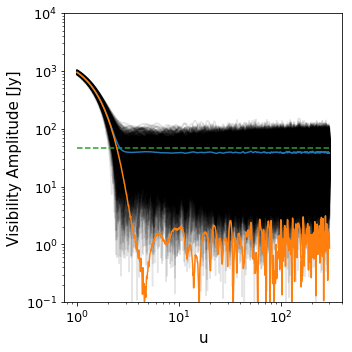

In [68]:
#index = int(fourier_beam.shape[0]/2)

labelfontsize = 15
tickfontsize = 13
figure = pyplot.figure(figsize = (5, 5))

realised_axes = figure.add_subplot(111)
realised_axes.plot(uv_coordinates, numpy.abs(realised_vis), 'k', alpha = 0.1)
realised_axes.plot(uv_coordinates, sky_rms, 'C2--', )
#realised_axes.plot(uv_beam[0, :], numpy.abs(fourier_beam[index, :])*1.5*1e4, 'k',linewidth = 2)
realised_axes.plot(uv_coordinates, numpy.sum(numpy.abs(realised_vis), axis = 1)/n_realisations)
realised_axes.plot(uv_coordinates, numpy.abs(averaged_vis))

realised_axes.set_xlabel('u', fontsize = labelfontsize )
realised_axes.set_ylabel('Visibility Amplitude [Jy]', fontsize = labelfontsize)

realised_axes.tick_params(axis='both', which='major', labelsize=tickfontsize)
realised_axes.set_xscale('log')
realised_axes.set_yscale('log')
#realised_axes.set_xlim(uv_coordinates[0, :].min(),uv_coordinates[0, :].max())
realised_axes.set_ylim(1e-1,1e4)
figure.tight_layout()


figure.savefig("../../../Plots/Analytic_Covariance/Mean_Visibility_Amplitudes.png")

pyplot.show()

### The Fisher Information Matrix

Considering that all baselines do measure some amount of signal with some variance which we can describe. What does that imply for our FIM? Is it really different for different tiles? What happens to the tiles in that participate in the EoR range. We would expect the variance of a tile gain to depend on its location in the array. 

Considering that "core" tiles participate in a wide range of baselines, similarly for the "hex" tiles, but less so for the outer tiles. We expect that core/hex tiles have better constrains on their gain solutions. We will compute the full Fisher Information Matrix, and also look at the inverse to see how the variance depends on tile location and how strong the correlation of variances are between different tiles.

In [1]:
import sys
import numpy
import powerbox
from matplotlib import pyplot
sys.path.append("../")

In [2]:
from radiotelescope import RadioTelescope
from skymodel import SkyRealisation
from radiotelescope import ideal_gaussian_beam
from Single_Dipole_PS_Impact_OO import uv_list_to_baseline_measurements
from analytic_covariance import sky_covariance
from analytic_covariance import beam_covariance

In [3]:
def visibility_extractor(baseline_table_object, sky_image, frequency, antenna1_response,
                            antenna2_response, padding_factor = 3):

    apparent_sky = sky_image * antenna1_response * numpy.conj(antenna2_response)
    visibility_grid, uv_coordinates = powerbox.dft.fft(
        numpy.fft.ifftshift(numpy.pad(apparent_sky, padding_factor * apparent_sky.shape[0], 
                                      mode="constant"), axes=(0, 1)), L=2*(2 * padding_factor + 1), 
        axes=(0, 1))

    measured_visibilities = uv_list_to_baseline_measurements(baseline_table_object, frequency, visibility_grid,
                                                             uv_coordinates)

    return measured_visibilities


def get_observations(source_population = None, baseline_table = None, frequency_range = None, 
                      beam_type = 'gaussian', oversampling=2):
   
    observations = numpy.zeros((baseline_table.number_of_baselines, len(frequency_range)), dtype=complex)
    sky_cube, l_coordinates = source_population.create_sky_image(baseline_table = baseline_table,
                                                                 frequency_channels=frequency_range,
                                                                 oversampling=2)    
    for frequency_index in range(len(frequency_range)):
        
        ll, mm = numpy.meshgrid(l_coordinates, l_coordinates)

        # Create Beam
        #############################################################################
        antenna_response1 = ideal_gaussian_beam(ll, mm, frequency_range[frequency_index])
        antenna_response2 = antenna_response1.copy()
        
        observations[..., frequency_index] = visibility_extractor(baseline_table, 
                                                                  sky_cube[...,frequency_index], 
                                                                  frequency_range[frequency_index],
                                                                  antenna_response1, 
                                                                  antenna_response2)
    return observations

In [36]:
frequency_range = numpy.linspace(135,165, 2)*1e6
path = "../Data/MWA_All_Coordinates_Cath.txt"
output_path = "/data/rjoseph/Hybrid_Calibration/Tile_Pertubation/Simulation_Output/Gain_Sim/"

sky_param = "random"
n_realisations = 2

telescope = RadioTelescope(load = True, path=path)
baseline_table = telescope.baseline_table


for i in range(n_realisations):
    source_population = SkyRealisation(sky_type=sky_param, seed = i )
    signal = get_observations(source_population, baseline_table, frequency_range)
    numpy.save(output_path + "visibility_realisation_{i}", signal )

FileNotFoundError: [Errno 2] No such file or directory: '/data/rjoseph/Hybrid_Calibration/Tile_Pertubation/Simulation_Output/Gain_Sim/visibility_realisation_{i}.npy'

In [29]:
antenna_id = telescope.antenna_positions.antenna_ids
n_antennas = len(antenna_id)


FIM = numpy.zeros((n_antennas, n_antennas, len(frequency_range)))

for j in range(n_antennas):
    for k in range(n_antennas):
        #find all baselines in which these antennas participate    
        baseline_indices = numpy.where(((baseline_table.antenna_id1 == antenna_id[j])|
                                    (baseline_table.antenna_id2 == antenna_id[j])) &
                                    ((baseline_table.antenna_id1 == antenna_id[k])|
                                    (baseline_table.antenna_id2 == antenna_id[k])))[0]
                                    
            #Compute the covariances for each baseline
        for l in range(len(baseline_indices)):
            u = baseline_table.u(frequency = frequency_range[0])[l]
            v = baseline_table.v(frequency = frequency_range[0])[l]
                
            data_covariance = sky_covariance(u, v, frequency_range) + beam_covariance(u, v, frequency_range)
                
            FIM[j, k, :] += 2*numpy.real(numpy.abs(signal[baseline_indices[l], :])**2/numpy.diag(data_covariance))


In [32]:
covariance = numpy.zeros((n_antennas, n_antennas, len(frequency_range)))
for i in range(len(frequency_range)):
    covariance[..., i] = numpy.linalg.pinv(FIM[..., i])

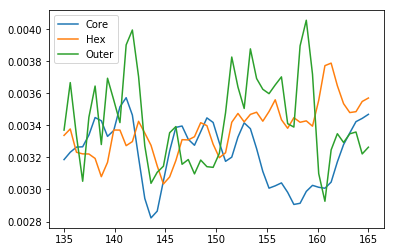

In [33]:
core_index = numpy.where(antenna_id == 36)[0]
hex_index = numpy.where(antenna_id == 1036)[0]
outer_index = numpy.where(antenna_id == 81)[0]

#find 
pyplot.plot(frequency_range/1e6, covariance[core_index, core_index, :].flatten(), label = "Core")
pyplot.plot(frequency_range/1e6, covariance[hex_index, hex_index,:].flatten(), label = "Hex")
pyplot.plot(frequency_range/1e6, covariance[outer_index, outer_index,:].flatten(), label = "Outer")
pyplot.legend()
pyplot.show()

(8128, 100)


### Baseline Weights

In [69]:
import sys
import numpy
import powerbox
from matplotlib import pyplot
sys.path.append("../")

In [70]:
from radiotelescope import RadioTelescope


In [93]:
def matrix_constructor_alternate(telescope):
    antennas = telescope.antenna_positions.antenna_ids
    baselines = telescope.baseline_table
    array_matrix = numpy.zeros((2*baselines.number_of_baselines, 2*len(antennas)))
    
    for i in range(baselines.number_of_baselines):
        index1 = numpy.where(antennas == baselines.antenna_id1[i])[0]
        index2 = numpy.where(antennas == baselines.antenna_id2[i])[0]
        
        #Fill in the real rows
        array_matrix[2*i, 2*index1] = 1
        array_matrix[2*i, 2*index2] = 1
        
        #Fill in the imaginary rows
    
        array_matrix[2*i + 1, 2*index1 + 1] = 1
        array_matrix[2*i + 1, 2*index2 + 1] = -1
    
    constrained_matrix = array_matrix[:, 2:]
    return constrained_matrix

def matrix_constructor_shifted(telescope):
    antennas = telescope.antenna_positions.antenna_ids
    baselines = telescope.baseline_table
    array_matrix = numpy.zeros((2*baselines.number_of_baselines, 2*len(antennas)))
    
    for i in range(baselines.number_of_baselines):
        index1 = numpy.where(antennas == baselines.antenna_id1[i])[0]
        index2 = numpy.where(antennas == baselines.antenna_id2[i])[0]
        
        #Fill in the real rows
        array_matrix[i, index1] = 1
        array_matrix[i, index2] = 1
        
        #Fill in the imaginary rows
    
        array_matrix[baselines.number_of_baselines + i, len(antennas) + index1] = 1
        array_matrix[baselines.number_of_baselines + i, len(antennas) + index2] = -1
    
    constrained_matrix = numpy.zeros((array_matrix.shape[0], array_matrix.shape[1] - 2))
    
    constrained_matrix[:, :len(antennas)- 1] = array_matrix[:, 1:len(antennas)]
    constrained_matrix[:, len(antennas)- 1:] = array_matrix[:, len(antennas) + 1:]
    
    return constrained_matrix

def matrix_constructor_wrong(telescope):
    antennas = telescope.antenna_positions.antenna_ids
    baselines = telescope.baseline_table
    array_matrix = numpy.zeros((baselines.number_of_baselines, len(antennas)))
    
    for i in range(baselines.number_of_baselines):
        index1 = numpy.where(antennas == baselines.antenna_id1[i])[0]
        index2 = numpy.where(antennas == baselines.antenna_id2[i])[0]
        
        #Fill in the real rows
        array_matrix[i, index1] = 1
        array_matrix[i, index2] = 1

    return array_matrix

def matrix_constructor_double(telescope):
    antennas = telescope.antenna_positions.antenna_ids
    baselines = telescope.baseline_table
    array_matrix = numpy.zeros((baselines.number_of_baselines, 2*len(antennas)))
    
    for i in range(baselines.number_of_baselines):
        index1 = numpy.where(antennas == baselines.antenna_id1[i])[0]
        index2 = numpy.where(antennas == baselines.antenna_id2[i])[0]
        
        #Fill in the real rows
        array_matrix[i, index1] = 1
        array_matrix[i, len(antennas) +  index2] = 1

    return array_matrix

In [98]:
path = "../Data/MWA_Compact_Coordinates.txt"
telescope = RadioTelescope(load = True, path=path)
array_matrix = matrix_constructor_alternate(telescope)


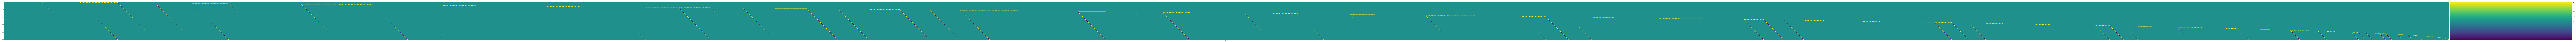

In [99]:
#%matplotlib notebook
%matplotlib inline
pyplot.rcParams['xtick.bottom'] = pyplot.rcParams['xtick.labelbottom'] = False
pyplot.rcParams['xtick.top'] = pyplot.rcParams['xtick.labeltop'] = True

figure = pyplot.figure(figsize = (500,50))
axes = figure.add_subplot(111)
plot = axes.imshow(array_matrix.T)
colorbar(plot)
axes.set_xlabel("Baseline Number")
axes.set_ylabel("Antenna Number")
pyplot.show()

1.201560260587909


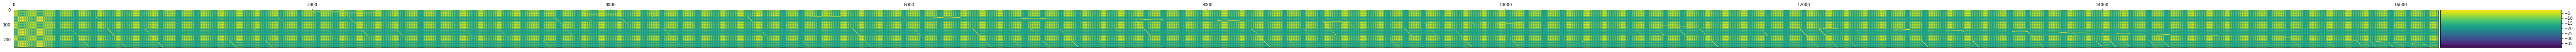

In [100]:
print(numpy.log10(numpy.linalg.cond(array_matrix)))

#%matplotlib notebook
inverse_array_matrix = numpy.linalg.pinv(array_matrix)

figure = pyplot.figure(figsize = (110,20))
axes = figure.add_subplot(111)
plot = axes.imshow(numpy.log10(numpy.abs(inverse_array_matrix)))
colorbar(plot)
pyplot.show()

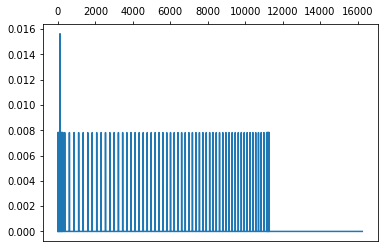

In [84]:
pyplot.plot(numpy.abs(inverse_array_matrix[111]))
pyplot.show()